# Core idea of the model
We are dealing with a tabular dataset with 6 features and 42656 rows. MY first idea, when i saw the nature of the dataset, was to use a Multilayer Perceptron model, however, after an analysis of the features, i decided to create a model which uses RNN, more specifically I tried several models with Bidirectional LSTM and GRU



In [ ]:
pip install imblearn

In [ ]:
import pandas as pd
import os
import shutil
import io
import re
import string
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Bidirectional, GRU
from keras.layers.core import  Activation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/vittoriapeppoloni/parkReviews/main/parkReviews.csv", encoding_errors='ignore')
data


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


# **1)Input**
After examinating all the fields, my first intuition was to drop all the features and just keeping Review_text and Rating. At the end, i kept all the features for my training data.

In [ ]:
#data = pd.read_csv("parkReviews.csv", encoding_errors='ignore')
data

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


I started my preprocessing treating my features in different ways:

> Review_Text: the first idea was to clean the text and then create a vocabulary with all the unique words in order to mapping them to an index and finally represent them as one-hot vectors with size=voc_size. After an exaustive try, i decided to use the **Tokenizer** class in order to easily preprocess my text and convert it in a suitable format for my RNN



In [ ]:
# Text cleaning
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    return text

In [ ]:
# Preprocess Review_Text
data["Review_Text"] = data["Review_Text"].apply(clean_text)

In [ ]:
data["Review_Text"].value_counts()

disneyland  we love it  the service is incomparable which makes up for the expense  would like a little more crowd control however                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Review_Text"])
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Encode Review_Text
X_text = tokenizer.texts_to_sequences(data["Review_Text"])
X_text = pad_sequences(X_text, padding="post")


> Reviewer_Location, Branch, Year_Month: I encoded categorical features with **LabelEncoder**



In [ ]:
# Encode categorical features
categorical_features = ["Reviewer_Location", "Branch", "Year_Month"]
encoder = LabelEncoder()
X_categorical = data[categorical_features].apply(encoder.fit_transform)

# 2) Output layer
Since it is a Multiclass classification I expected to have as output a vector composed of ratings from 1 to 5

In [ ]:
# Combine encoded features
X = pd.concat([pd.DataFrame(X_text), X_categorical], axis=1).to_numpy()

# Set Rating as the target variable
y_temp = data["Rating"].to_numpy()

i = 0

for i in range(0, len(y_temp)):
    y_temp[i] = y_temp[i] - 1

y = np.array(y_temp, dtype=int)


In [ ]:
# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the preprocessed data
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
X_train

(34124, 3937)
(8532, 3937)
(34124,)
(8532,)


array([[  10,   11,   49, ...,  106,    2,  108],
       [1059,   12,    9, ...,    8,    0,   36],
       [  53,  195,   39, ...,  152,    2,   95],
       ...,
       [ 140,   44,    8, ...,  152,    2,   52],
       [  21,  344,    5, ...,    8,    1,  103],
       [  27,   11,  163, ...,  153,    0,   76]])

In [ ]:
# Pad sequences to a maximum length
max_sequence_length = 300  # Adjust this value based on your data and computational resources
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_sequence_length, padding='post')

# 3) Activation and Loss function


> Activation function: they are very important since they introduce non-linearity in our training.
For my model I choose as internal activation function the **Sigmoid** and for the output layer the **Softmax activation function** that will give us as output a vector of probabilities that represent the membership degree of the corresponding class



> Loss function: also known as Cost function, compute the dissimilarity/discrepancy beteeween the true value e the value predicted by our model. For my model I used the **Sparse Categorical Cross-Entropy** since my target are integer numbers



# 4)Initializers, Regularizers, Normalizers



> Initializers: to keep the variance of my weights equal over each layers and preventing in this way the problem of Exploding/Vanishing Gradients, I used **Xavier/Glorot initializer** that works on the number of input and output layers.


> Regularizers: I adopted **Dropout**, which is a technique that dropping off some random neurons brings the model to learn more roboust and generalized representations. Also, I combined it with **L1**,**L2** regularization techniques: they work acting on the Loss function, adding a cost to it and their aim is that of take the distribution of the weight vale more regular.


> Normalizers: it would be possibile ot use a **Batch Normalization** technique in order to prevent the Internal Covariance shift problem, however, since this technique acts a sort of regularization, I decided to skip it.








# 5) Hyperparameters:

*   n_epochs
*   n_hidden layers
*   learning rate
*   batch_size
*   dropout_rate
*   optimizers

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, output_dim=128, input_length=max_sequence_length))
model.add(keras.layers.Bidirectional(GRU(32,  kernel_initializer='glorot_uniform', dropout=0.2)))
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
# Evaluate the model
_, accuracy = model.evaluate(X_val, y_val)
print('Validation Accuracy:', accuracy)

# Make predictions
predictions = model.predict(X_val)
predicted_ratings = np.argmax(predictions, axis=1)


Epoch 1/10
1067/1067 [==============================] - 41s 29ms/step - loss: 1.1826 - accuracy: 0.5435 - val_loss: 1.1800 - val_accuracy: 0.5389
Epoch 2/10
1067/1067 [==============================] - 26s 24ms/step - loss: 1.1679 - accuracy: 0.5428 - val_loss: 1.1754 - val_accuracy: 0.5394
Epoch 3/10
1067/1067 [==============================] - 25s 23ms/step - loss: 1.1631 - accuracy: 0.5438 - val_loss: 1.1717 - val_accuracy: 0.5413
Epoch 4/10
1067/1067 [==============================] - 25s 23ms/step - loss: 1.1579 - accuracy: 0.5454 - val_loss: 1.1750 - val_accuracy: 0.5374
Epoch 5/10
1067/1067 [==============================] - 25s 23ms/step - loss: 1.1558 - accuracy: 0.5451 - val_loss: 1.1728 - val_accuracy: 0.5394
Epoch 6/10
1067/1067 [==============================] - 25s 23ms/step - loss: 1.1533 - accuracy: 0.5459 - val_loss: 1.1740 - val_accuracy: 0.5430
Epoch 7/10
1067/1067 [==============================] - 25s 23ms/step - loss: 1.1516 - accuracy: 0.5460 - val_loss: 1.1745 -

# 6) Model evaluation
I will evaluate my model on two main points:


> ***6.1 Metrics***: i will focus on looking the increasing of my **accuracy** and the the sime time on the decreasing of my Loss function.










In [ ]:
precision = precision_score(y_val, predicted_ratings, average='macro')
recall = recall_score(y_val, predicted_ratings, average='macro')
f1 = f1_score(y_val, predicted_ratings, average='macro')

# Print evaluation metrics (precision, recall, F1 score)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

In [ ]:
print('Predicted Ratings:', predicted_ratings)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_val, predicted_ratings)

last_five_classes = cm[-5:, -5:]

plt.figure(figsize=(8, 6))
sns.heatmap(last_five_classes, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

class_labels = ['1', '2', '3', '4', '5']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

plt.show()


In [ ]:
# Plot learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



>**6.2** ***Randomized Search:*** in order to find the best hyperparameters I performed firstly a **Randomized Search **, however, the provided GPU in Google Colab was not sufficient to support all the steps in the training that I needed to achieve. Hence I trained several models by changing initializers, regularizers, normalizers and the other hyperparmaters manually, here i upload the more insteresting models that i did while looking for the best one.



1. **Bidirectional LSTM** (two layers): I created this model with two layers of LSTM with Xavier/Glorot initialization and a Dropout layer.
I trained the model over 20 epochs, with the other hyperparameters equal to my ultimated GRU model.

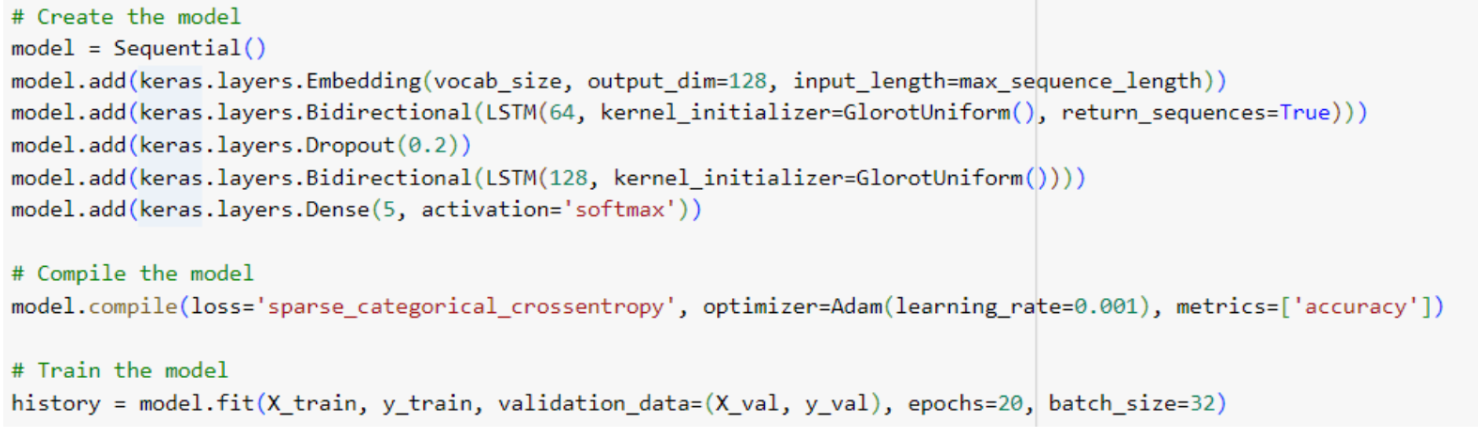





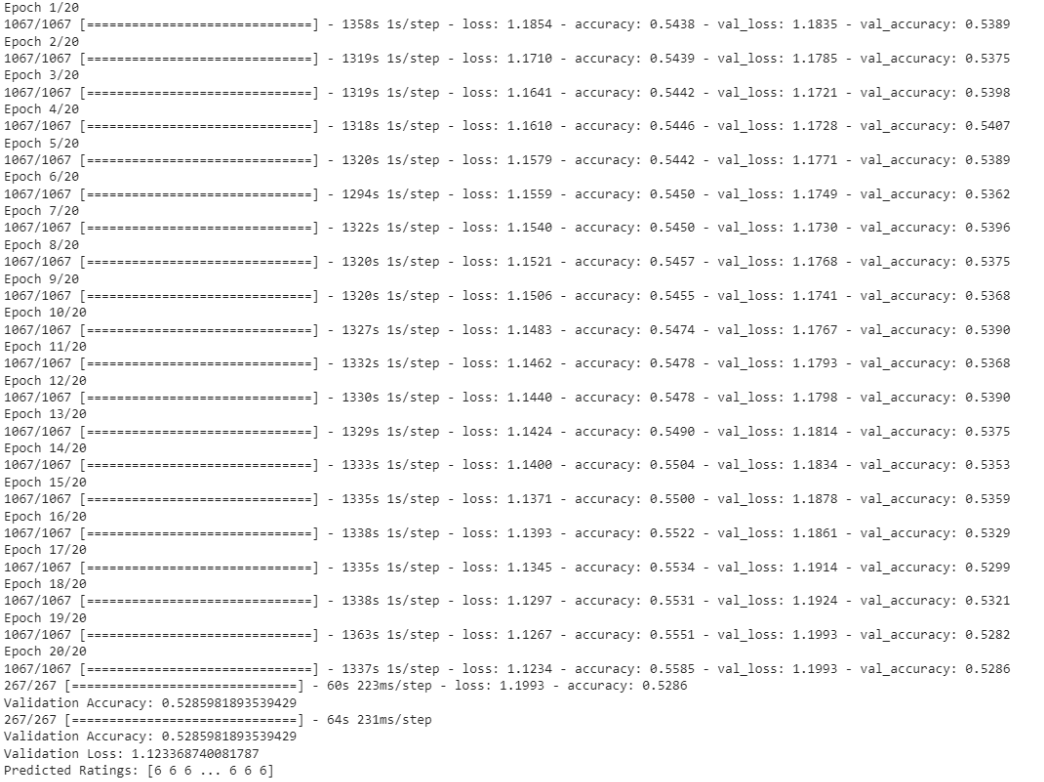

2) **Bidirectional LSTM** (two layers): in this model I took the n_units of the layers equal and in addition I added L1, L2 regularizers

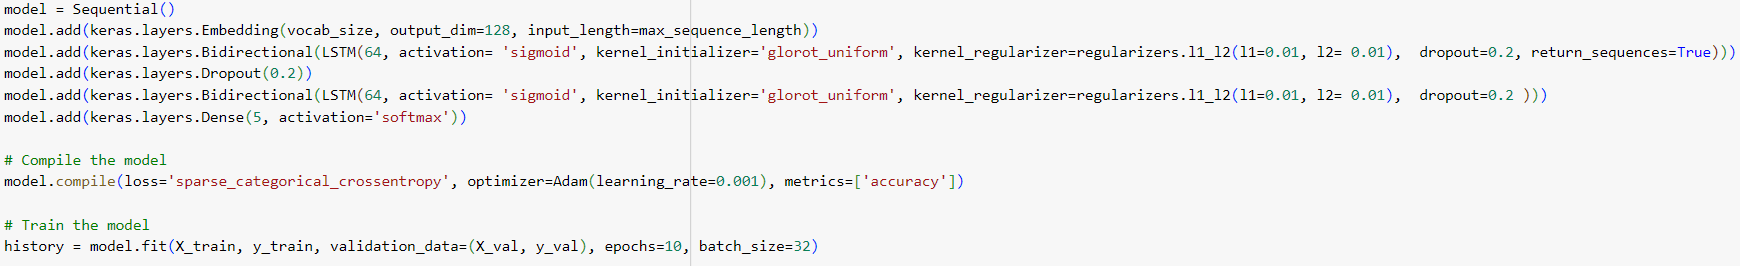

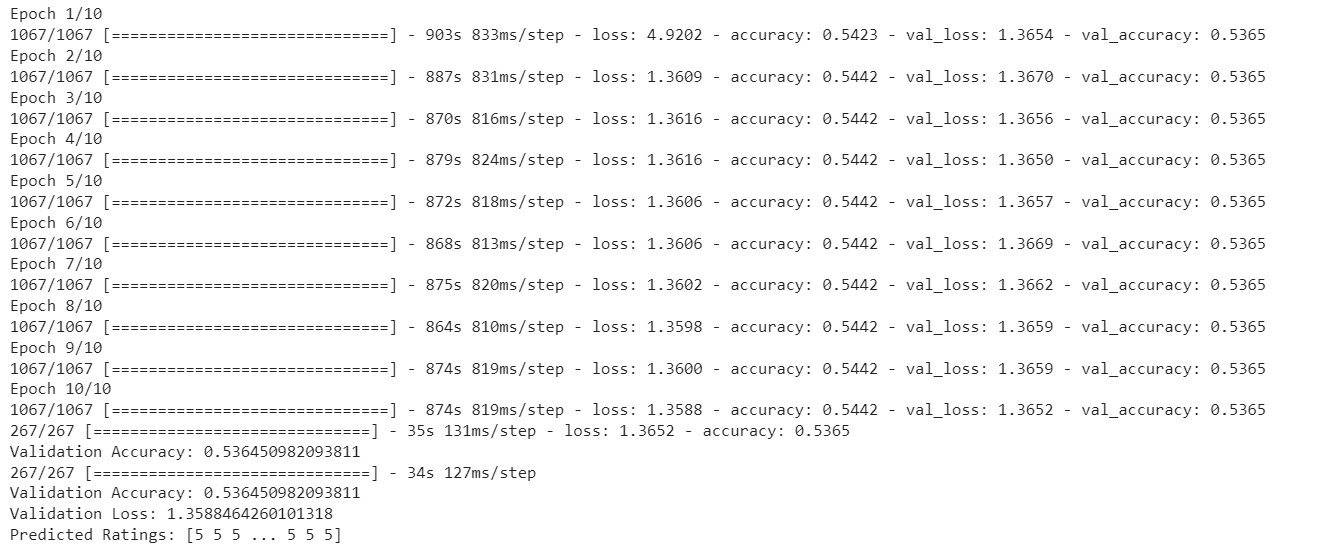

Since these models with Bidirectional LSTM required a lot of time for computation, I decided to try some other RNNs that cuold perform in a similar or ebtter way than them


**3) Bidirectional GRU:** I kept always two layers with different units and same inizitializers, regularizers and optimzer parameters

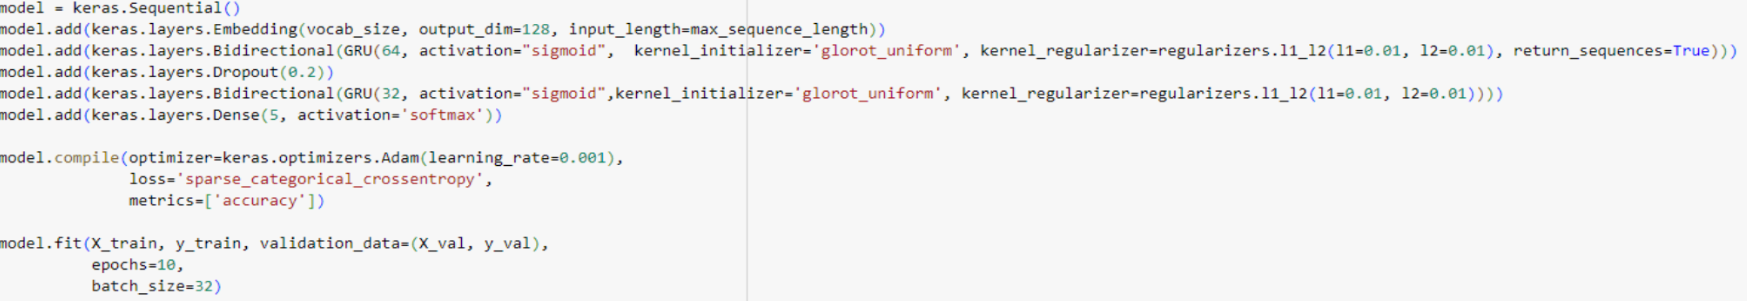

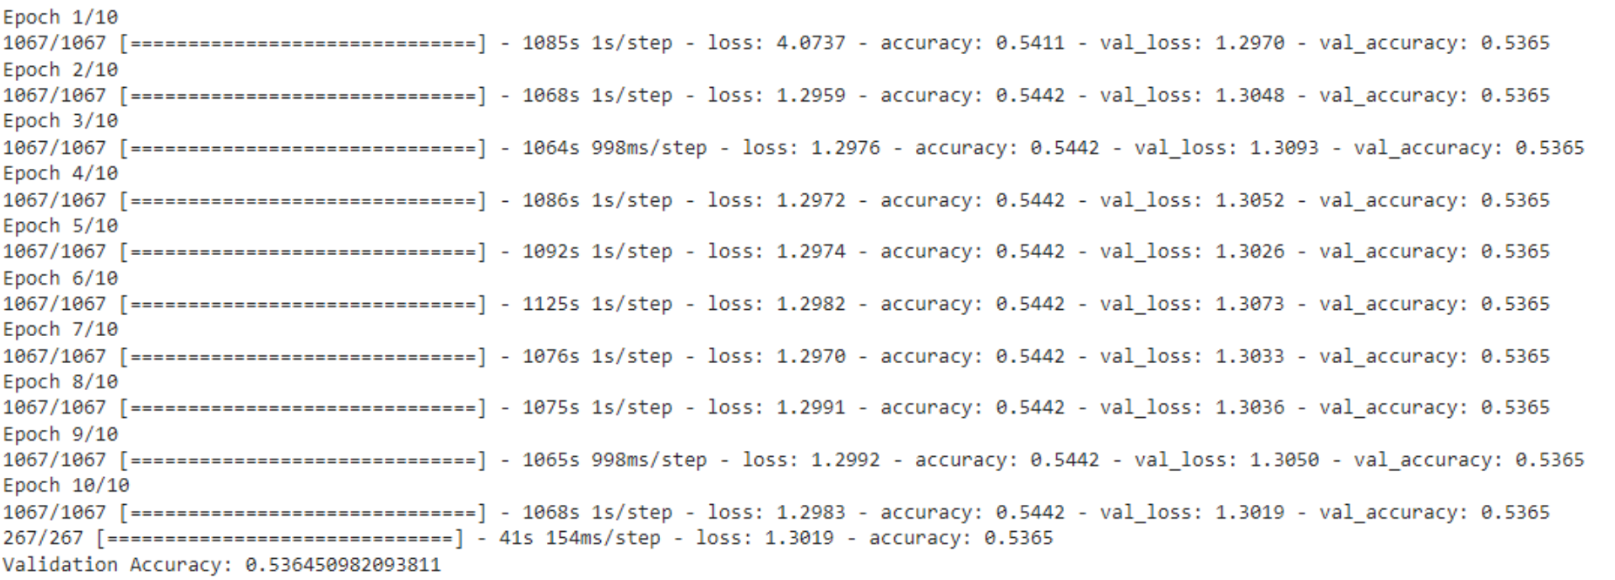

**4) Bidirectional GRU**: the last model that I wanted to try was still a bidirectional GRU with the implementation of a BatchNormalization layer; however, maybe due to the small number of layers that I choose, it doesn't perform as well as I expected

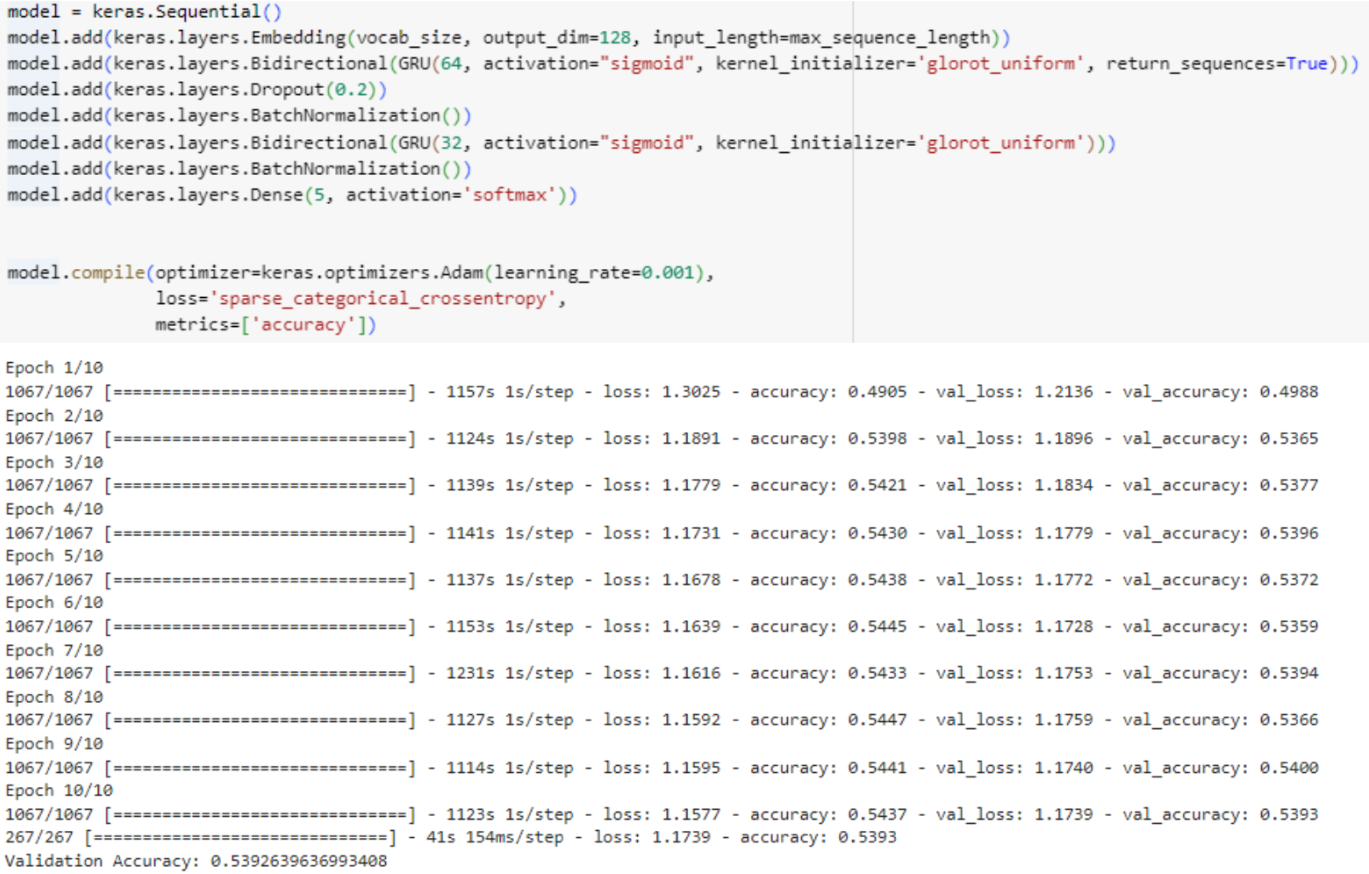

All these models have firstly the issue that the accuracy is not sufficiently high but, in addition, have the problem of the predicted ratings: due to the imbalance of the classes, my model's prediction is always equal to one single class; this problem can be achieved by the introduction of some samplers during the train.
Hence, I tried to fix this problem by implementing **Random Under Sampler ** which removes samples from the majority class that is dominating the datase in order to keep the dsitribution balanced.

Therefore, I before the splitting:

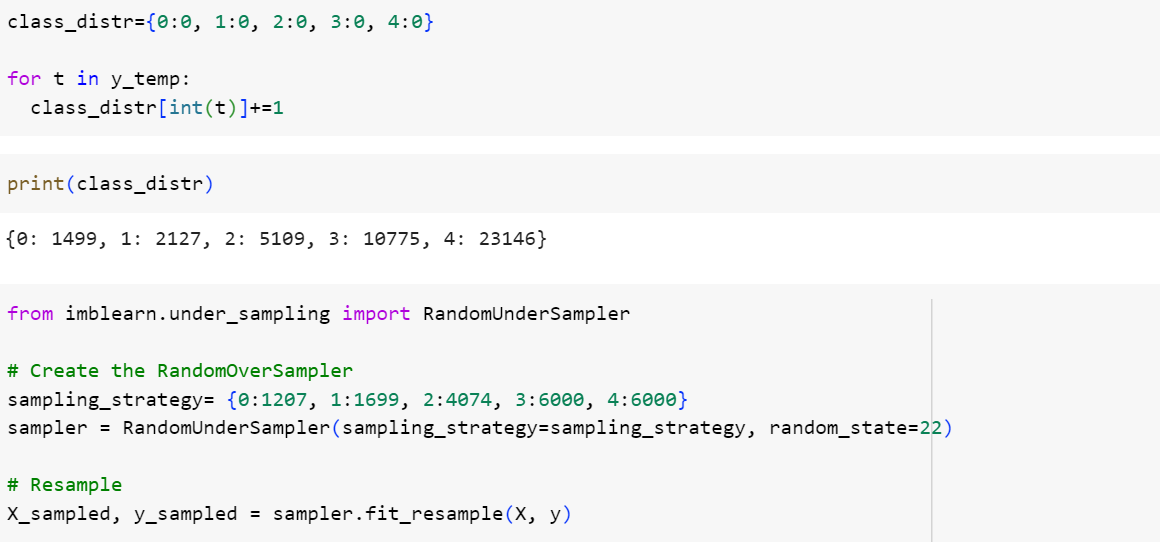

However, I tried to use this sampler with my bidirectional GRU model but the problem was not solved even after the training, as I expected the accuracy was lower and the problem of the imbalance of the classes was not solve since the prediction's ratings belong always to the same class

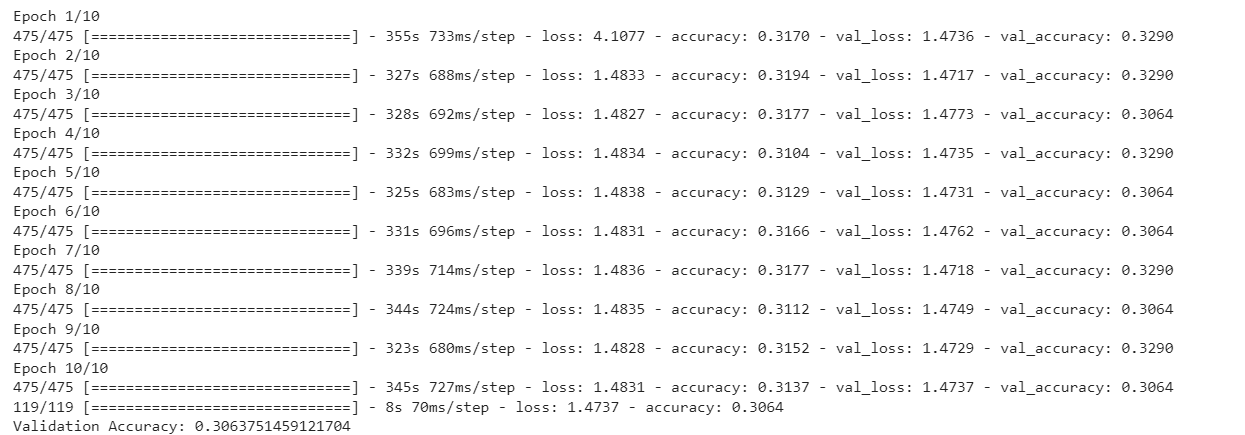